# Maximum likelihood estimation of a transmission string

In this tutorial we take a look at how to quickly fit a light curve, and estimate the maximum-likelihood transmission string. Let us start by simulating a transit light curve for a known 7-parameter transmission string.

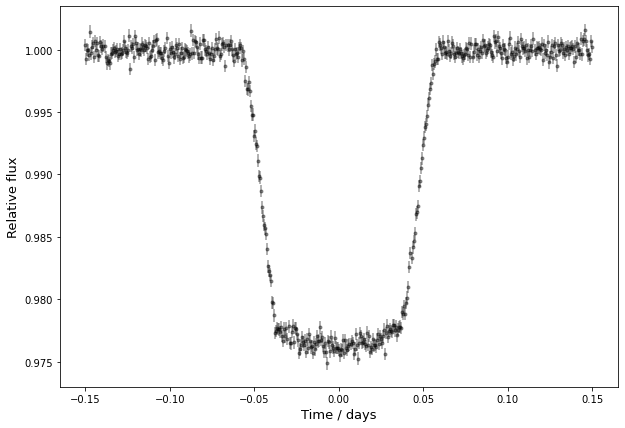

In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from harmonica import HarmonicaTransit


np.random.seed(12)

times = np.linspace(-0.15, 0.15, 500)
r_mean = np.array([0.15])
r_dev = np.random.uniform(-0.1, 0.1, size=6)
injected_r = np.concatenate([r_mean, r_dev * r_mean])

ht = HarmonicaTransit(times)
ht.set_orbit(t0=0., period=4., a=11., inc=87. * np.pi / 180.)
ht.set_stellar_limb_darkening(np.array([0.027, 0.246]), limb_dark_law='quadratic')
ht.set_planet_transmission_string(injected_r)

theta = np.linspace(-np.pi, np.pi, 1000)
injected_transmission_string = ht.get_planet_transmission_string(theta)

flux_sigma = 500.e-6 * np.ones(times.shape[0])
flux_errs = np.random.normal(loc=0., scale=flux_sigma, size=times.shape[0])
observed_fluxes = ht.get_transit_light_curve() + flux_errs

plt.figure(figsize=(10, 7))
plt.errorbar(times, observed_fluxes, yerr=flux_sigma, fmt=".k", alpha=0.4)
plt.xlabel('Time / days', fontsize=13)
plt.ylabel('Relative flux', fontsize=13)
plt.show()

This transit light curve corresponds to the following transmission string:

r = 0.150-0.010cos(t)+0.007sin(t)+0.001cos(2t)-0.015sin(2t)+0.013cos(3t)+3.000sin(3t)


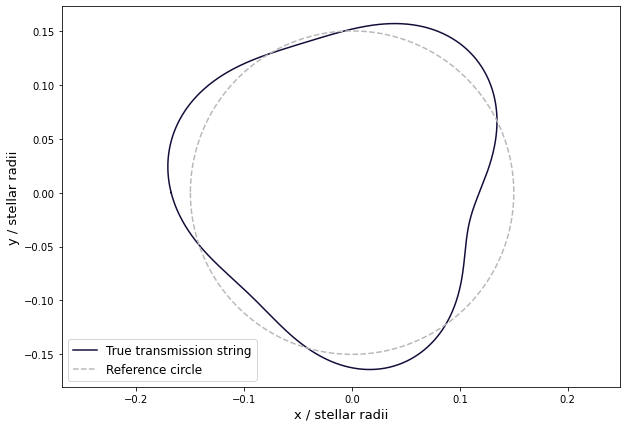

In [2]:
print("r = {0:.3f}{1:+.3f}cos(t){2:+.3f}sin(t)"
      "{4:+.3f}cos(2t){5:+.3f}sin(2t)"
      "{6:+.3f}cos(3t){7:+.3f}sin(3t)".format(*injected_r, 3))

plt.figure(figsize=(10, 7))
plt.gca().set_aspect("equal", "datalim")
plt.plot(injected_transmission_string * np.cos(theta), 
         injected_transmission_string * np.sin(theta), 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(injected_r[0] * np.cos(theta), injected_r[0] * np.sin(theta), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("x / stellar radii", fontsize=13)
plt.ylabel("y / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

Now you can apply Harmonica and estimate the transmission string parameters which maximise the likelihood of the simulated data. To do this we make use of the $\texttt{scipy.optimize}$ module.

In [3]:
from scipy.optimize import curve_fit


def transit_model(_, *params):
    ht.set_planet_transmission_string(np.array(params))
    model = ht.get_transit_light_curve()

    return model


popt, pcov = curve_fit(
    transit_model, times, observed_fluxes, sigma=flux_sigma,
    p0=np.concatenate([r_mean, r_dev * r_mean]),
    method='lm')

print("r = {0:.3f}{1:+.3f}cos(t){2:+.3f}sin(t)"
      "{4:+.3f}cos(2t){5:+.3f}sin(2t)"
      "{6:+.3f}cos(3t){7:+.3f}sin(3t)".format(*popt, 3))

r = 0.150-0.008cos(t)+0.007sin(t)+0.002cos(2t)-0.015sin(2t)+0.013cos(3t)+3.000sin(3t)


This fast method gives you a point estimate of the best-fit parameters. Take a look at the fitted transit light curve:

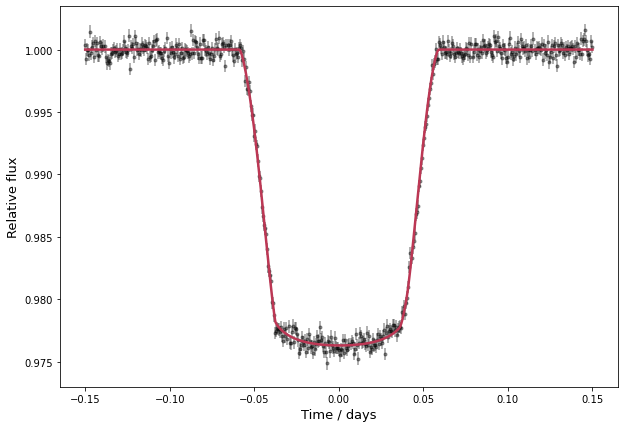

In [4]:
ht.set_planet_transmission_string(popt)

plt.figure(figsize=(10, 7))
plt.errorbar(times, observed_fluxes, yerr=flux_sigma, fmt=".k", alpha=0.4, zorder=1)
plt.plot(times, ht.get_transit_light_curve(), c=cm.inferno(0.5), lw=2.5, zorder=2)
plt.xlabel('Time / days', fontsize=13)
plt.ylabel('Relative flux', fontsize=13)
plt.show()

And here is the estimated transmission string:

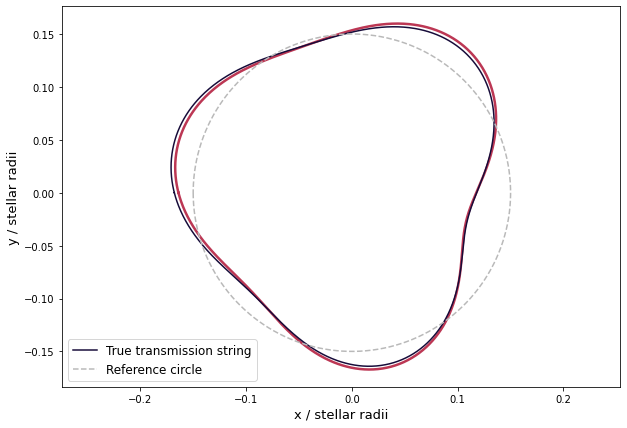

In [5]:
plt.figure(figsize=(10, 7))
plt.gca().set_aspect("equal", "datalim")
plt.plot(ht.get_planet_transmission_string(theta) * np.cos(theta), 
         ht.get_planet_transmission_string(theta) * np.sin(theta), 
         c=cm.inferno(0.5), lw=2.5)
plt.plot(injected_transmission_string * np.cos(theta), 
         injected_transmission_string * np.sin(theta), 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(injected_r[0] * np.cos(theta), injected_r[0] * np.sin(theta), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("x / stellar radii", fontsize=13)
plt.ylabel("y / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

You may find it preferable to visualise these transmission strings in polar coordinates.

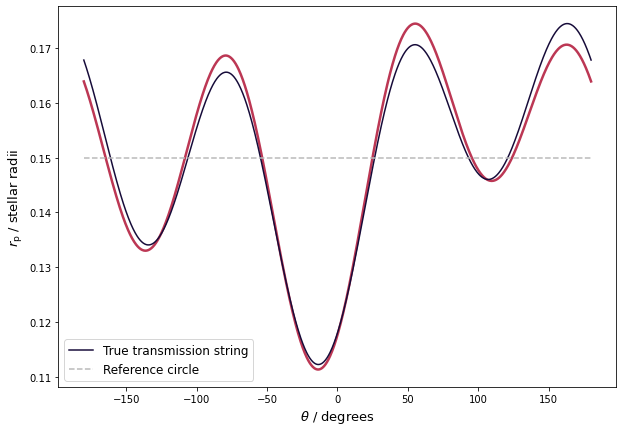

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(theta * 180. / np.pi, ht.get_planet_transmission_string(theta), 
         c=cm.inferno(0.5), lw=2.5)
plt.plot(theta * 180. / np.pi, injected_transmission_string, 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(theta * 180. / np.pi, injected_r[0] * np.ones(theta.shape[0]), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

Further to this point estimate, you may also use the curvature of the likelihood function to inform the uncertainty in your estimates. The inverse of the Hessian matrix, used in the minimisation proceedure, is equivalent to the asymptotic covariance matrix. The standard errors of the transmission string parameters can then easily be calculated; and in fact, we already have this in hand from our curve fitting.

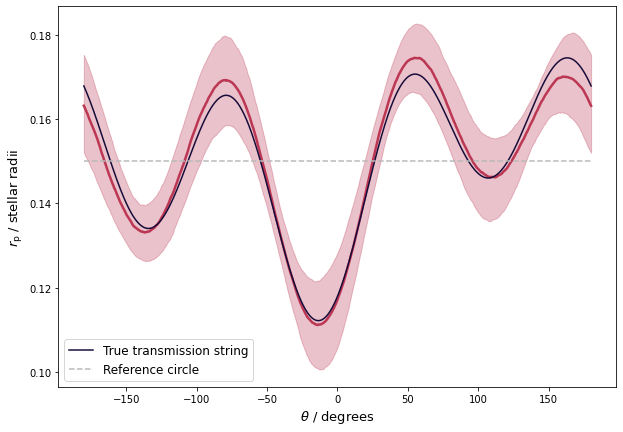

In [7]:
# Sample MLE transmission string parameter distributions.
n_mc_samples = 1000
mle_r_sigma = np.sqrt(np.diag(pcov))
mle_r_samples = np.random.normal(loc=popt, scale=mle_r_sigma, size=(n_mc_samples, len(popt)))
ht.set_planet_transmission_string(mle_r_samples)
ts_samples = ht.get_planet_transmission_string(theta)

# Get 16th, 50th, 84th percentiles.
ts_16, ts_50, ts_84 = np.percentile(ts_samples, [16., 50., 84.], axis=0)

plt.figure(figsize=(10, 7))
plt.plot(theta * 180. / np.pi, ts_50, c=cm.inferno(0.5), lw=2.5)
plt.fill_between(theta * 180. / np.pi, ts_16, ts_84, color=cm.inferno(0.5), alpha=0.3)
plt.plot(theta * 180. / np.pi, injected_transmission_string, 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(theta * 180. / np.pi, injected_r[0] * np.ones(theta.shape[0]), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()